# Demo environment

This notebook will be used as an introduction to the control and image constructs available within the demo environment of both the robot interfaces and the camera interfaces.

We will cover the steps necessary to connect to and control the robot while also collecting image data from the cameras mounted around and on the robotic arm.

## Camera Access

In this demo we'll be utilizing Intel's [RealSense D435i](https://www.intelrealsense.com/depth-camera-d435i/) for use with our robotic arm. We'll not only want to view these images, but we'll want to collect them as we perform tasks, as well. There any many use cases and approaches one can take when peforming tasks using robotics arms such as these that span the areas of standard supervised, unsupervised, and reinforcement learning. For this reason there will likely be a few combinations of data collection that we may want to employ.

We will start with building the software constructs necessary to view and collect data from the Intel RealSense camera that is connected to the arm of our robot.

In [1]:
import torch

model = torch.hub.load('pytorch/vision:v0.5.0', 'fcn_resnet101', pretrained=True)
model.eval()

Using cache found in /home/robarm/.cache/torch/hub/pytorch_vision_v0.5.0


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
import pyrealsense2 as rs
import numpy as np
import cv2
import os
from ipywidgets import Image, HBox, Output, Text
import IPython
import PIL.Image
from matplotlib import pyplot as plt
import sys
from skimage.transform import resize
import threading
import time
import math
import traitlets
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as kimg
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

model = ResNet50(weights='imagenet')

def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

def class_to_str(value):
    #return f"Class : {value[1]}, Probability : {value[2]}"
    return value

class Camera(traitlets.HasTraits): 
    
    value = traitlets.Any()
    img_class = traitlets.Any()
    running = traitlets.Bool(default_value=False)
#     # Enable or disable inference for this model
#     inference = traitlets.Bool(default_value=False)
    
    def __init__(self, serial_num: str, inference: bool, *args, **kwargs):
        super(Camera, self).__init__(*args, **kwargs)
        
        self.serial_num = serial_num
        
        # Camera pipelines
        self.pipeline = rs.pipeline()
        self.config = rs.config()
        self.config.enable_device(self.serial_num)
        self.config.enable_stream(rs.stream.depth, int(640), int(480), rs.format.z16, 15)
        self.config.enable_stream(rs.stream.color, int(640), int(480), rs.format.bgr8, 15)

        self.pipeline.start(self.config)
        self._running = False
        self.inference = inference
        
        self.value = None
        self.img_class = None
    
    def stream(self):
        while True:
            self.frames = self.pipeline.wait_for_frames()
            self.depth_frame = self.frames.get_depth_frame()
            self.color_frame = self.frames.get_color_frame()
            depth_image = np.asanyarray(self.depth_frame.get_data())
            color_image = np.asanyarray(self.color_frame.get_data())
            
            if self.inference == True:
                img = resize(color_image, (224,224))
                x = kimg.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)

                preds = model.predict(x)
                decoded_preds = decode_predictions(preds, top=3)[0]
                self.img_class = decoded_preds = decoded_preds[0][1]
            else:
                pass
            
            depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.3), cv2.COLORMAP_JET)
            self.value = np.hstack((color_image, depth_colormap))
            
            
    @traitlets.observe('running')
    def view_camera(self, change):
        if change['new'] and not change['old']:
            self._running = True
            self.thread = threading.Thread(target=self.stream)
            self.thread.start()
        if change['old'] and not change['new']:
            self._running = False
            # join thread to kill it
            self.thread.join()

In [ ]:
import urllib
url, filename = ("/home/robarm/Documents/roadsoda/cat.jpg", "cat.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [2]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open('/home/robarm/Documents/roadsoda/cat.jpg')
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]

In [3]:
output_predictions = output.argmax(0)
print(output.argmax(0))

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')


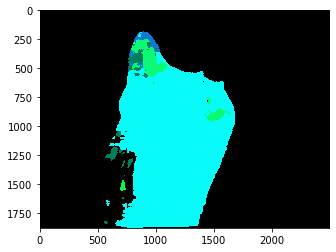

In [4]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)
# plt.show()


In [ ]:
cam_2 = Camera(serial_num='923322072160', inference=True)
image_widget_2 = Image(format='jpeg')
class_widget_2 = Text(placeholder='Object Class Shown Here')

def update_image_2(change):
    image_2 = change['new']
    image_widget_2.value = bgr8_to_jpeg(image_2)
    
def update_class_2(change):
    class_2 = change['new']
    class_widget_2.value = class_2

In [ ]:
cam_2.running = True
cam_2.observe(update_image_2, names='value')

In [ ]:
camera_link1 = traitlets.dlink((cam_2, 'value'), (image_widget_2, 'value'), transform=bgr8_to_jpeg)
display(image_widget_2)

In [ ]:
cam_2.observe(update_class_2, names='img_class')
class_link1 = traitlets.dlink((cam_2, 'img_class'), (class_widget_2, 'value'), transform=class_to_str)
display(class_widget_2)

In [ ]:
cam = Camera(serial_num='937422071477', inference=False)
#cam_1.serial_num=''
image_widget = Image(format='jpeg')

def update_image(change):
    image = change['new']
    jpg_img = bgr8_to_jpeg(image)    
    image_widget.value = jpg_img

In [ ]:
cam.running = True
cam.observe(update_image, names='value')

In [ ]:
camera_link0 = traitlets.dlink((cam, 'value'), (image_widget, 'value'), transform=bgr8_to_jpeg)
display(image_widget)

In [ ]:
del cam

In [ ]:
img_path = 'cat_2.jpg'

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

print(f'Predicted: {decode_predictions(preds, top=3)[0]}')

## Robotic Arm Access

The arm that we are utilizing in this demo is the [ufactory xarm](https://www.xarm.cc/). The company is generous enough to provide an open source python SDK for development against the platform. We will be utilizing this SDK heavily in this demo. It is assumed that the controller being used (in our case an Ubuntu 18.04) already has this SDK installed. If it does not, please follow the installation instructions found [here](https://github.com/xArm-Developer/xArm-Python-SDK#installation)

In [96]:
from xarm.wrapper import XArmAPI

arm = XArmAPI('192.168.1.244')
arm.motion_enable(enable=True)
arm.set_mode(0)
arm.set_state(state=0)
speed = 60

main-socket connect 192.168.1.244 success
report-socket connect 192.168.1.244 success
is_old_protocol: False
version_number: 1.3.1
=============sync_all
[motion_enable], xArm is not ready to move
[set_state], xArm is ready to move


In [93]:
arm.set_state(state=0)

[SDK][ERROR][2020-01-22 17:09:35][utils.py:22] - - xArm is not connect


-1

In [47]:
arm.set_servo_detach(4)

=============sync_all


1

ControllerError, code: 14
ControllerError, code: 14
ControllerError, code: 14


In [119]:
arm.set_servo_angle(1)

(0, 0.0)

In [118]:
arm.set_servo_angle(angle=[0, 15, 0, -90,-180], speed=speed, wait=False)

0

In [62]:
for i in range(50):
    if i%2 == 0:
        arm.set_servo_angle(angle=[0, 0, -20, -90, 0], speed=speed, wait=False)
        
    else:
        arm.set_servo_angle(angle=[0,0,-20,-30,0], speed=speed, wait=False)

while True:
    print(arm.get_servo_angle())

(0, [0.0, 0.0, -30.000012857270395, 85.32052037163919, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 85.32052037163919, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 84.7213784052709, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 84.7213784052709, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 84.7213784052709, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 84.7213784052709, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 84.12212184734356, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 84.12212184734356, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 84.12212184734356, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 84.12212184734356, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 83.52280799363673, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 83.52280799363673, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 83.52280799363673, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 83.52280799363673, 0.0, 0.0, 0.0])
(0, [0.0, 

(0, [0.0, 0.0, -30.000012857270395, 60.1512292766758, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 60.1512292766758, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 60.1512292766758, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 60.1512292766758, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 58.952658865041634, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 58.952658865041634, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 58.35340230711431, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 58.35340230711431, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 58.35340230711431, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 58.35340230711431, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 57.75414574918698, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 57.75414574918698, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 57.75414574918698, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 57.75414574918698, 0.0, 0.0, 0.0])
(0, [0.0

(0, [0.0, 0.0, -30.000012857270395, 35.581080148080716, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 35.581080148080716, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 35.581080148080716, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 34.98182359015338, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 34.98182359015338, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 34.38250973644654, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 34.38250973644654, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 34.38250973644654, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 33.78325317851922, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 33.78325317851922, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 33.78325317851922, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 33.183996620591884, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 33.183996620591884, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 33.183996620591884, 0.0, 0.0, 0.0])


(0, [0.0, 0.0, -30.000012857270395, 11.010931019485621, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 11.010931019485621, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 10.411674461558293, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 10.411674461558293, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 10.411674461558293, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 10.411674461558293, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 9.812360607851453, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 9.812360607851453, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 9.812360607851453, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 9.213104049924125, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 9.213104049924125, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 9.213104049924125, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 9.213104049924125, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, 8.613847491996797, 0.0, 0.0, 0.0])


(0, [0.0, 0.0, -30.000012857270395, -13.559218109109471, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -14.1584746670368, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -14.757788520743642, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -14.757788520743642, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -15.35704507867097, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -15.35704507867097, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -15.35704507867097, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -15.35704507867097, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -15.956301636598297, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -15.956301636598297, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -15.956301636598297, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -16.555615490305136, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -16.555615490305136, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -16.555615490305136, 

(0, [0.0, 0.0, -30.000012857270395, -38.129367237704564, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -38.129367237704564, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -38.7286810914114, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -38.7286810914114, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -38.7286810914114, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -39.32793764933873, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -39.32793764933873, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -39.32793764933873, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -39.927194207266055, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -39.927194207266055, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -39.927194207266055, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -39.927194207266055, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -40.52645076519339, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -30.000012857270395, -40.52645076519339, 0.0, 

(0, [0.0, 0.0, -29.258433583032566, -52.96616663839674, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -29.120236162847014, -53.51907091069799, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -29.120236162847014, -53.51907091069799, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -29.120236162847014, -53.51907091069799, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.9752205448994, -54.09901879092941, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.82636610972441, -54.69455112318838, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.82636610972441, -54.69455112318838, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.82636610972441, -54.69455112318838, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.67630846317965, -55.29466711780841, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.67630846317965, -55.29466711780841, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.67630846317965, -55.29466711780841, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.52625081663489, -55.89489770398746, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.52625081663489, -55.89489770398746, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -28.52625081663489, -55.89489770398746, 0.0, 0.0, 0.0])
(0,

(0, [0.0, 0.0, -23.124347428361975, -77.50268314441765, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.97428978181721, -78.10291373059671, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.97428978181721, -78.10291373059671, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.824232135272446, -78.70314431677576, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.824232135272446, -78.70314431677576, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.824232135272446, -78.70314431677576, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.824232135272446, -78.70314431677576, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.674174488727687, -79.3033749029548, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.674174488727687, -79.3033749029548, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.674174488727687, -79.3033749029548, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.674174488727687, -79.3033749029548, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.524116842182924, -79.90354819335434, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.524116842182924, -79.90354819335434, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -22.524116842182924, -79.90354819335434, 0.0, 0.0, 0.0]

(0, [0.0, 0.0, -20.000008571513593, -87.53185098194662, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -87.014527388723, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -87.014527388723, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -86.45887291900513, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -86.45887291900513, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -86.45887291900513, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -85.87646132025463, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -85.87646132025463, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -85.87646132025463, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -85.87646132025463, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -85.27886633993319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -85.27886633993319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -85.27886633993319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -85.27886633993319, 0.0, 0.0, 0.

(0, [0.0, 0.0, -20.000008571513593, -62.407537073901, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -62.407537073901, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -62.407537073901, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.80564491011605, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.80564491011605, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.80564491011605, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.80564491011605, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.203752746331126, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.203752746331126, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.203752746331126, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.203752746331126, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -60.601860582546195, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -60.601860582546195, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -60.601860582546195, 0.0, 0.

(0, [0.0, 0.0, -20.000008571513593, -37.73047402073448, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -37.73047402073448, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -37.73047402073448, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -37.12858185694956, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -36.52668969316463, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -36.52668969316463, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -35.92485482515921, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -35.92485482515921, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -35.92485482515921, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -35.32296266137428, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -35.32296266137428, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -35.32296266137428, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -35.32296266137428, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -35.32296266137428, 0.0, 0.0

(0, [0.0, 0.0, -20.000008571513593, -36.52668969316463, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -37.12858185694956, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -37.12858185694956, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -37.73047402073448, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.332366184519415, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.332366184519415, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.332366184519415, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.332366184519415, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.93420105252483, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.93420105252483, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.93420105252483, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.93420105252483, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -39.53609321630976, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -39.53609321630976, 0.0,

(0, [0.0, 0.0, -20.000008571513593, -61.80564491011605, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.80564491011605, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -61.80564491011605, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -62.407537073901, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -62.407537073901, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -63.0093719419064, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -63.0093719419064, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -63.0093719419064, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -63.61126410569133, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -63.61126410569133, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -63.61126410569133, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -63.61126410569133, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -64.21315626947626, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -64.21315626947626, 0.0, 0.0, 0.0])

(0, [0.0, 0.0, -20.000008571513593, -86.45887291900513, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -86.45887291900513, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -87.014527388723, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -87.014527388723, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -87.014527388723, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -87.53185098194662, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -87.53185098194662, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -87.53185098194662, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.00104612037924, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.00104612037924, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.00104612037924, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.00104612037924, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.00104612037924, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.41987826861987, 0.0, 0.0, 0.0]

(0, [0.0, 0.0, -20.000008571513593, -78.65828172141701, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -78.65828172141701, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -78.05638955763209, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -78.05638955763209, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -77.45449739384716, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -77.45449739384716, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -77.45449739384716, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -77.45449739384716, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -76.85260523006222, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -76.85260523006222, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -76.85260523006222, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -76.85260523006222, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -76.25077036205681, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -76.25077036205681, 0.0, 0.0

(0, [0.0, 0.0, -20.000008571513593, -53.98121866825051, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -53.98121866825051, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -53.379326504465574, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -53.379326504465574, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -53.379326504465574, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -53.379326504465574, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -53.379326504465574, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -52.77743434068065, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -52.77743434068065, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -52.77743434068065, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -52.17559947267524, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -52.17559947267524, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -52.17559947267524, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -52.17559947267524, 0.0

(0, [0.0, 0.0, -20.000008571513593, -30.625396290655686, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.625396290655686, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.407729624285487, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.407729624285487, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.240425948107287, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.240425948107287, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.240425948107287, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.240425948107287, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.240425948107287, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.123370670562057, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.123370670562057, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.123370670562057, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.123370670562057, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.12337067056

(0, [0.0, 0.0, -20.000008571513593, -45.55490026260003, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -45.55490026260003, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -46.15679242638496, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -46.75868459016989, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -46.75868459016989, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -46.75868459016989, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -46.75868459016989, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -47.36051945817531, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -47.36051945817531, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -47.36051945817531, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -47.36051945817531, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -47.96241162196024, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -47.96241162196024, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -47.96241162196024, 0.0, 0.0

(0, [0.0, 0.0, -20.000008571513593, -70.23196331576654, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -70.23196331576654, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -70.83385547955146, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -70.83385547955146, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -71.43569034755689, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -71.43569034755689, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -71.43569034755689, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -72.03758251134181, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -72.03758251134181, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -72.03758251134181, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -72.03758251134181, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -72.03758251134181, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -72.63947467512673, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -72.63947467512673, 0.0, 0.0

(0, [0.0, 0.0, -20.000008571513593, -89.99998127603166, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.99998127603166, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.99809051530772, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.99809051530772, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.98456871134265, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.98456871134265, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.98456871134265, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.94795670823378, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.94795670823378, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.94795670823378, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.94795670823378, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.87662346274, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.87662346274, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.87662346274, 0.0, 0.0, 0.0])
(

(0, [0.0, 0.0, -20.000008571513593, -70.23196331576654, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -69.63007115198161, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -69.02817898819667, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -69.02817898819667, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -69.02817898819667, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -69.02817898819667, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -68.42628682441175, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -68.42628682441175, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -68.42628682441175, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -67.82445195640632, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -67.82445195640632, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -67.82445195640632, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -67.82445195640632, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -67.2225597926214, 0.0, 0.0,

(0, [0.0, 0.0, -20.000008571513593, -45.55490026260003, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -44.953008098815104, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -44.953008098815104, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -44.35111593503017, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -44.35111593503017, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -43.74928106702476, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -43.74928106702476, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -43.74928106702476, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -43.74928106702476, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -43.14738890323982, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -43.14738890323982, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -43.14738890323982, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -43.14738890323982, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -43.14738890323982, 0.0, 0

(0, [0.0, 0.0, -20.000008571513593, -30.893311355658856, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.893311355658856, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.893311355658856, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.21153211507452, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.21153211507452, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.580115864682178, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.580115864682178, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.580115864682178, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.998948012922806, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.998948012922806, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.998948012922806, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.998948012922806, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -31.998948012922806, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -32.4681431513554

(0, [0.0, 0.0, -20.000008571513593, -55.184945700040856, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -55.184945700040856, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -55.184945700040856, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -55.78683786382579, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -56.38873002761071, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -56.38873002761071, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -56.38873002761071, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -56.990622191395644, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -56.990622191395644, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -56.990622191395644, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -56.990622191395644, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -57.592457059401056, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -57.592457059401056, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -57.592457059401056

(0, [0.0, 0.0, -20.000008571513593, -79.86200875320736, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -79.86200875320736, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -79.86200875320736, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -80.46390091699229, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -81.06579308077723, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -81.06579308077723, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -81.06579308077723, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -81.06579308077723, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -81.66768524456215, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -81.66768524456215, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -81.66768524456215, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -81.66768524456215, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -82.26952011256758, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -82.26952011256758, 0.0, 0.0

(0, [0.0, 0.0, -20.000008571513593, -85.27886633993319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -85.27886633993319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -84.67703147192776, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -84.67703147192776, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -84.07519660392236, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -84.07519660392236, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -84.07519660392236, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -83.47330444013743, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -83.47330444013743, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -83.47330444013743, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -83.47330444013743, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -83.47330444013743, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -82.8714122763525, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -82.8714122763525, 0.0, 0.0, 

(0, [0.0, 0.0, -20.000008571513593, -60.601860582546195, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -60.00002571454079, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -59.39813355075586, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -59.39813355075586, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.79624138697093, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.79624138697093, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.79624138697093, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.79624138697093, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.19434922318599, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.19434922318599, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.19434922318599, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.19434922318599, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.19434922318599, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -57.592457059401056, 0.0, 0

(0, [0.0, 0.0, -20.000008571513593, -35.92485482515921, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -35.32296266137428, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.721127793368865, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.721127793368865, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.721127793368865, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.721127793368865, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.12353281304741, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.12353281304741, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.12353281304741, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -33.54112121429693, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -33.54112121429693, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -33.54112121429693, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -33.54112121429693, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -33.54112121429693, 0.0,

(0, [0.0, 0.0, -20.000008571513593, -38.93420105252483, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.93420105252483, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -38.93420105252483, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -39.53609321630976, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -39.53609321630976, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.13798538009469, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.13798538009469, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.13798538009469, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.73987754387962, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.73987754387962, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.73987754387962, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.73987754387962, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -41.341769707664554, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -41.341769707664554, 0.0, 0

(0, [0.0, 0.0, -20.000008571513593, -63.61126410569133, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -63.61126410569133, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -64.21315626947626, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -64.81504843326118, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -64.81504843326118, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -64.81504843326118, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -64.81504843326118, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -66.01877546505153, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -66.01877546505153, 0.0, 0.0

(0, [0.0, 0.0, -20.000008571513593, -88.00104612037924, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.00104612037924, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.41987826861987, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.41987826861987, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.41987826861987, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.78846201822753, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.78846201822753, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -88.78846201822753, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.10668277764319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.10668277764319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.10668277764319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.10668277764319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.10668277764319, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.37465513842588, 0.0, 0.0

(0, [0.0, 0.0, -20.000008571513593, -76.85260523006222, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -76.25077036205681, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -76.25077036205681, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -76.25077036205681, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -75.64887819827187, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -75.64887819827187, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -75.04698603448695, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -75.04698603448695, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -75.04698603448695, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -75.04698603448695, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -74.44509387070202, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -74.44509387070202, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -74.44509387070202, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -74.44509387070202, 0.0, 0.0

(0, [0.0, 0.0, -20.000008571513593, -51.573707308890306, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -51.573707308890306, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -51.573707308890306, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -50.971815145105374, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -50.971815145105374, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -50.36992298132045, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -50.36992298132045, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -50.36992298132045, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -50.36992298132045, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0

(0, [0.0, 0.0, -20.000008571513593, -30.123370670562057, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.052037425068267, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.052037425068267, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.01542542195941, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.01542542195941, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.001903617994323, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.001903617994323, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.001903617994323, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.001903617994323, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.000012857270395, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.000012857270395, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.000012857270395, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.000012857270395, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -30.0000128572703

(0, [0.0, 0.0, -20.000008571513593, -47.96241162196024, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -47.96241162196024, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -47.96241162196024, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -48.56430378574517, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.1661959495301, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.1661959495301, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.1661959495301, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.1661959495301, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -49.76803081753552, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -50.36992298132045, 0.0, 0.0, 0.

(0, [0.0, 0.0, -20.000008571513593, -72.63947467512673, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -72.63947467512673, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -73.24136683891167, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -73.24136683891167, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -73.24136683891167, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -73.84320170691709, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -73.84320170691709, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -73.84320170691709, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -73.84320170691709, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -74.44509387070202, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -74.44509387070202, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -74.44509387070202, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -74.44509387070202, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -75.04698603448695, 0.0, 0.0

(0, [0.0, 0.0, -20.000008571513593, -89.87662346274, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.75956818519477, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.75956818519477, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.75956818519477, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.59226450901656, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.59226450901656, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.59226450901656, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.59226450901656, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.59226450901656, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.37465513842588, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.37465513842588, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.37465513842588, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.37465513842588, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -89.37465513842588, 0.0, 0.0, 0

(0, [0.0, 0.0, -20.000008571513593, -67.82445195640632, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -67.2225597926214, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -67.2225597926214, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -66.62066762883647, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -66.62066762883647, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -66.01877546505153, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -66.01877546505153, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -66.01877546505153, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -66.01877546505153, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -65.41694059704612, 0.0, 0.0, 

(0, [0.0, 0.0, -20.000008571513593, -43.14738890323982, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -42.5454967394549, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -42.5454967394549, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -41.943604575669966, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -41.943604575669966, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -41.943604575669966, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -41.341769707664554, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -41.341769707664554, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -41.341769707664554, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -41.341769707664554, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.73987754387962, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.73987754387962, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.73987754387962, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -40.73987754387962, 0.0

(0, [0.0, 0.0, -20.000008571513593, -31.998948012922806, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -32.468143151355434, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -32.98546674457906, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -32.98546674457906, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -32.98546674457906, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -33.54112121429693, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -33.54112121429693, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -33.54112121429693, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -33.54112121429693, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.12353281304741, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.12353281304741, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.12353281304741, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.12353281304741, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -34.721127793368865, 0.0, 

(0, [0.0, 0.0, -20.000008571513593, -57.592457059401056, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.19434922318599, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.19434922318599, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.19434922318599, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.79624138697093, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.79624138697093, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.79624138697093, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -58.79624138697093, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -59.39813355075586, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -59.39813355075586, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -59.39813355075586, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -59.39813355075586, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -59.39813355075586, 0.0, 0.0, 0.0])
(0, [0.0, 0.0, -20.000008571513593, -60.00002571454079, 0.0, 0.

KeyboardInterrupt: 

In [ ]:
for i in range(-10,-90):
    print(i)

In [ ]:
ctx = rs.context()
for d in ctx.devices:
    print(d)